In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rcan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 100
LR = 1e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_2"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_2/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_2/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_2/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = alpha_model = rcan.RCAN(scale=2, latent_dim=128, num_rg=2, num_rcab=2, reduction=2, out_channels=2).to(device).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 2283650


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

RCAN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgs): Sequential(
    (0): RG(
      (rg): Sequential(
        (0): RCAB(
          (rcab): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ChannelAttention(
              (attention): Sequential(
                (0): AdaptiveAvgPool2d(output_size=1)
                (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
                (2): ReLU(inplace=True)
                (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
                (4): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (rcab): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kerne

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


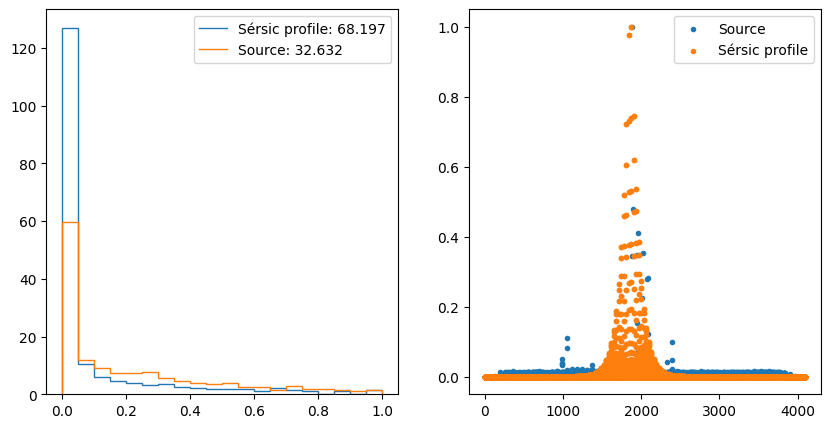

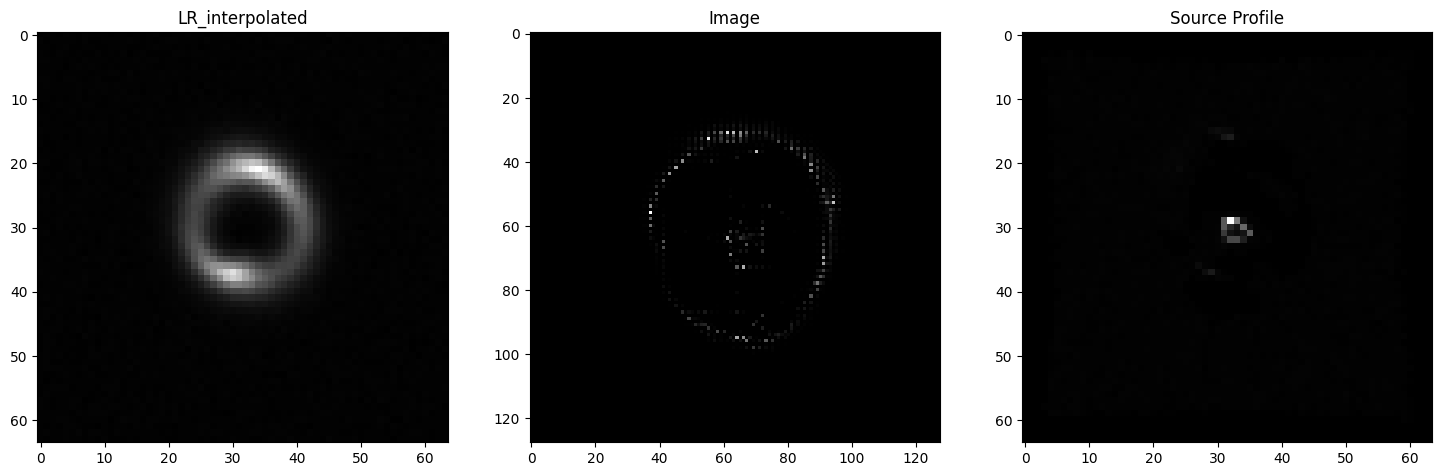

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [01:04<00:00, 12.65it/s]


Training at epoch 1/100: 0.013601136521673607 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 31.94it/s]


Validation at epoch 1/100: 0.009763362799205033 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [01:05<00:00, 12.50it/s]


Training at epoch 2/100: 0.009080274450574466 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 30.86it/s]


Validation at epoch 2/100: 0.009743741841292841 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 3/100: 0.008177796725695047 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:06<00:00, 31.16it/s]


Validation at epoch 3/100: 0.008221548488911462 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 4/100: 0.007793131284415722 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 30.46it/s]


Validation at epoch 4/100: 0.007849472775763172 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 5/100: 0.007453827223941389 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 31.05it/s]


Validation at epoch 5/100: 0.0067311762375574374 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [01:06<00:00, 12.27it/s]


Training at epoch 6/100: 0.006929635882888932 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 30.67it/s]


Validation at epoch 6/100: 0.007311319274937403 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [01:06<00:00, 12.29it/s]


Training at epoch 7/100: 0.006586397386283846 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 30.67it/s]


Validation at epoch 7/100: 0.006878868220191375 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [01:06<00:00, 12.31it/s]


Training at epoch 8/100: 0.006201136994230402 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 30.50it/s]


Validation at epoch 8/100: 0.005755424499511719 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 9/100: 0.0058139778682779475 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 29.78it/s]


Validation at epoch 9/100: 0.005598456470989707 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [01:07<00:00, 12.05it/s]


Training at epoch 10/100: 0.0056997818698850955 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 30.30it/s]


Validation at epoch 10/100: 0.005977619621975752 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [01:07<00:00, 12.02it/s]


Training at epoch 11/100: 0.005644992756310335 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 29.96it/s]


Validation at epoch 11/100: 0.0054968800943564 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [01:08<00:00, 11.91it/s]


Training at epoch 12/100: 0.005531708276191469 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 29.49it/s]


Validation at epoch 12/100: 0.0054940206053502375 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [01:08<00:00, 11.95it/s]


Training at epoch 13/100: 0.005420776298634855 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 29.92it/s]


Validation at epoch 13/100: 0.005206561172563656 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [01:08<00:00, 11.93it/s]


Training at epoch 14/100: 0.005328357758402243 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 14/100: 0.0053774920456549705 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [01:08<00:00, 11.90it/s]


Training at epoch 15/100: 0.0051987101894565915 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 29.97it/s]


Validation at epoch 15/100: 0.004851704025093245 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [01:08<00:00, 11.92it/s]


Training at epoch 16/100: 0.0049347635541184265 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 29.87it/s]


Validation at epoch 16/100: 0.004816272259488989 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [01:08<00:00, 11.89it/s]


Training at epoch 17/100: 0.004694604867265799 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 29.95it/s]


Validation at epoch 17/100: 0.004434047723371609 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [01:08<00:00, 11.91it/s]


Training at epoch 18/100: 0.0044593566083623165 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:06<00:00, 29.78it/s]


Validation at epoch 18/100: 0.004514074172167218 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [01:08<00:00, 11.88it/s]


Training at epoch 19/100: 0.0043142822972845815 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:06<00:00, 29.25it/s]


Validation at epoch 19/100: 0.0042640905389014425 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 20/100: 0.004109031507087982 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:06<00:00, 30.02it/s]


Validation at epoch 20/100: 0.004816788458721896 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [01:08<00:00, 11.93it/s]


Training at epoch 21/100: 0.0040276367879271795 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:06<00:00, 29.75it/s]


Validation at epoch 21/100: 0.003978901697943609 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [01:08<00:00, 11.90it/s]


Training at epoch 22/100: 0.003961392171571362 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 30.22it/s]


Validation at epoch 22/100: 0.003829280955388266 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [01:07<00:00, 12.07it/s]


Training at epoch 23/100: 0.0038717185562549584 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:06<00:00, 30.56it/s]


Validation at epoch 23/100: 0.0037198968907343408 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 24/100: 0.0038175356241089142 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:06<00:00, 30.47it/s]


Validation at epoch 24/100: 0.003654442033639141 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 25/100: 0.003773517981993362 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 29.68it/s]


Validation at epoch 25/100: 0.0037782900217993576 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [01:08<00:00, 11.86it/s]


Training at epoch 26/100: 0.003751601848075641 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:06<00:00, 29.69it/s]


Validation at epoch 26/100: 0.003715443872280566 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [01:09<00:00, 11.82it/s]


Training at epoch 27/100: 0.0037434949224595636 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:06<00:00, 29.59it/s]


Validation at epoch 27/100: 0.003738780610957275 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [01:09<00:00, 11.82it/s]


Training at epoch 28/100: 0.003765676449071248 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 29.31it/s]


Validation at epoch 28/100: 0.003858270543609179 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 29/100: 0.0037646149673188703 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:07<00:00, 28.60it/s]


Validation at epoch 29/100: 0.0037060945349581126 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [01:10<00:00, 11.64it/s]


Training at epoch 30/100: 0.0037539416933249636 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 29.47it/s]


Validation at epoch 30/100: 0.0037939254577983826 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [01:09<00:00, 11.79it/s]


Training at epoch 31/100: 0.0037428118806679296 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 29.35it/s]


Validation at epoch 31/100: 0.003766455486708998 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [01:09<00:00, 11.81it/s]


Training at epoch 32/100: 0.0037602982152819472 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 29.50it/s]


Validation at epoch 32/100: 0.0037644960296650716 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [01:07<00:00, 12.07it/s]


Training at epoch 33/100: 0.0037451316385676003 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 31.20it/s]


Validation at epoch 33/100: 0.003695813327224233 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [01:06<00:00, 12.27it/s]


Training at epoch 34/100: 0.0037338448466970493 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Validation at epoch 34/100: 0.0037464825025595276 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 35/100: 0.0037223990554647417 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 31.95it/s]


Validation at epoch 35/100: 0.00372635330274409 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 36/100: 0.0037177493818579058 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 32.15it/s]


Validation at epoch 36/100: 0.0037350619677454233 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 37/100: 0.0036967492778785527 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 31.98it/s]


Validation at epoch 37/100: 0.003920602438715743 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 38/100: 0.003684057712591454 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 31.82it/s]


Validation at epoch 38/100: 0.0036897481346101144 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 39/100: 0.0036876284067665095 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 31.98it/s]


Validation at epoch 39/100: 0.003723572766152667 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [01:05<00:00, 12.50it/s]


Training at epoch 40/100: 0.003690188442466451 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 31.56it/s]


Validation at epoch 40/100: 0.003709775486997531 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 41/100: 0.003673733573854334 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 31.96it/s]


Validation at epoch 41/100: 0.003693602732656634 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [01:05<00:00, 12.46it/s]


Training at epoch 42/100: 0.003670652838670376 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 32.06it/s]


Validation at epoch 42/100: 0.0037053760332877144 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [01:05<00:00, 12.49it/s]


Training at epoch 43/100: 0.0036515899221686767 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 31.81it/s]


Validation at epoch 43/100: 0.003680119920960243 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 44/100: 0.003650408348881218 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 31.85it/s]


Validation at epoch 44/100: 0.0036961255302908388 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 45/100: 0.0036284394297456633 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 32.29it/s]


Validation at epoch 45/100: 0.003707351140203135 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [01:05<00:00, 12.51it/s]


Training at epoch 46/100: 0.0036276735561698945 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 31.74it/s]


Validation at epoch 46/100: 0.0037364509212327937 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 47/100: 0.0036282459942751782 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 31.84it/s]


Validation at epoch 47/100: 0.004219671378058253 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [01:05<00:00, 12.48it/s]


Training at epoch 48/100: 0.0036259091461497348 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 31.71it/s]


Validation at epoch 48/100: 0.0036432251388974057 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 49/100: 0.003601569440398439 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 31.24it/s]


Validation at epoch 49/100: 0.003642125055193901 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 50/100: 0.003602941606682269 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 31.66it/s]


Validation at epoch 50/100: 0.003649769008488339 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 51/100: 0.003607523730298613 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 31.51it/s]


Validation at epoch 51/100: 0.0037018503975488407 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 52/100: 0.003602473512657132 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 31.60it/s]


Validation at epoch 52/100: 0.0035972411735165927 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 53/100: 0.0036019935003280927 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 31.24it/s]


Validation at epoch 53/100: 0.0037377845477678025 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 54/100: 0.003605761885980838 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 31.93it/s]


Validation at epoch 54/100: 0.003838979675635403 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 55/100: 0.003584076558563895 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 31.57it/s]


Validation at epoch 55/100: 0.003665390702914082 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 56/100: 0.0035707826598310004 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 31.83it/s]


Validation at epoch 56/100: 0.0036085139430475 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [01:06<00:00, 12.35it/s]


Training at epoch 57/100: 0.003568233613965705 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 31.23it/s]


Validation at epoch 57/100: 0.003622752404315213 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 58/100: 0.0035773374855874434 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 32.14it/s]


Validation at epoch 58/100: 0.00374200465796771 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [01:06<00:00, 12.35it/s]


Training at epoch 59/100: 0.0035632644972864395 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 31.36it/s]


Validation at epoch 59/100: 0.0036380511124198336 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 60/100: 0.003579283003037904 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 31.82it/s]


Validation at epoch 60/100: 0.003664919188903536 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [01:05<00:00, 12.42it/s]


Training at epoch 61/100: 0.0035558614301193937 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 31.48it/s]


Validation at epoch 61/100: 0.0036125023228426763 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 62/100: 0.0035567724273777475 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 31.42it/s]


Validation at epoch 62/100: 0.003722566622765917 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 63/100: 0.0035572102973602856 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:06<00:00, 30.78it/s]


Validation at epoch 63/100: 0.003628328447138854 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [01:06<00:00, 12.35it/s]


Training at epoch 64/100: 0.003555501865990022 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 31.82it/s]


Validation at epoch 64/100: 0.0037222255395688852 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 65/100: 0.0035561883916813593 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 31.36it/s]


Validation at epoch 65/100: 0.0035930211774493556 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 66/100: 0.0035445297144892085 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 31.26it/s]


Validation at epoch 66/100: 0.003597862212736086 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 67/100: 0.0035455840161554147 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 31.30it/s]


Validation at epoch 67/100: 0.003739081021836576 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 68/100: 0.003561890171612521 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 68/100: 0.0036314457755389756 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [01:06<00:00, 12.34it/s]


Training at epoch 69/100: 0.003545201341302007 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 31.66it/s]


Validation at epoch 69/100: 0.0035857948561326836 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 70/100: 0.003542142061347727 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 31.12it/s]


Validation at epoch 70/100: 0.003591080120874241 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 71/100: 0.003538082022785995 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 31.34it/s]


Validation at epoch 71/100: 0.0035491781103808226 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 72/100: 0.0035503593949126255 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 31.33it/s]


Validation at epoch 72/100: 0.0035286431894728954 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 73/100: 0.0035431503555646126 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 31.21it/s]


Validation at epoch 73/100: 0.0036588823651054914 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 74/100: 0.0035257000634766307 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 31.39it/s]


Validation at epoch 74/100: 0.003572218336950185 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 75/100: 0.0035312046923482894 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 31.38it/s]


Validation at epoch 75/100: 0.003572499662564666 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 76/100: 0.0035398432958697653 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 29.93it/s]


Validation at epoch 76/100: 0.0035796580087466556 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [01:08<00:00, 11.97it/s]


Training at epoch 77/100: 0.0035415034285773903 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 29.88it/s]


Validation at epoch 77/100: 0.003587909711652672 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [01:08<00:00, 11.90it/s]


Training at epoch 78/100: 0.003519189349425883 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 29.32it/s]


Validation at epoch 78/100: 0.003755291955837725 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [01:08<00:00, 11.87it/s]


Training at epoch 79/100: 0.003526689722111412 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 79/100: 0.0035786386396662864 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [01:08<00:00, 11.88it/s]


Training at epoch 80/100: 0.003521604544492256 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 29.74it/s]


Validation at epoch 80/100: 0.003546422781130554 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [01:08<00:00, 11.92it/s]


Training at epoch 81/100: 0.0035268206882071414 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 29.64it/s]


Validation at epoch 81/100: 0.0035696128890027887 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [01:08<00:00, 11.84it/s]


Training at epoch 82/100: 0.003515355032183888 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 30.08it/s]


Validation at epoch 82/100: 0.0035548291703247853 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [01:08<00:00, 11.93it/s]


Training at epoch 83/100: 0.0035149079933534293 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 30.12it/s]


Validation at epoch 83/100: 0.0035974637002629383 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [01:08<00:00, 11.98it/s]


Training at epoch 84/100: 0.0035255536757747416 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 29.42it/s]


Validation at epoch 84/100: 0.003583903883255142 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 85/100: 0.003511331888148562 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 85/100: 0.0035593015045913704 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [01:08<00:00, 11.88it/s]


Training at epoch 86/100: 0.003515363642352395 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 29.99it/s]


Validation at epoch 86/100: 0.0035620756839931586 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [01:08<00:00, 11.92it/s]


Training at epoch 87/100: 0.0035065415152120303 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 29.90it/s]


Validation at epoch 87/100: 0.0036649222796161975 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [01:08<00:00, 11.93it/s]


Training at epoch 88/100: 0.0035156584533123196 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 29.68it/s]


Validation at epoch 88/100: 0.003524925368016257 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [01:08<00:00, 11.88it/s]


Training at epoch 89/100: 0.0035079913795925677 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 30.04it/s]


Validation at epoch 89/100: 0.003593636304596622 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [01:08<00:00, 12.00it/s]


Training at epoch 90/100: 0.003518690238136105 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 29.89it/s]


Validation at epoch 90/100: 0.003580712069592931 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 91/100: 0.0035185336098805357 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 29.72it/s]


Validation at epoch 91/100: 0.003557121497578918 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 92/100: 0.0035130485365002908 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 29.68it/s]


Validation at epoch 92/100: 0.0035314508211598096 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [01:08<00:00, 11.95it/s]


Training at epoch 93/100: 0.0035196326566887468 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 29.81it/s]


Validation at epoch 93/100: 0.003497608834603691 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [01:08<00:00, 11.90it/s]


Training at epoch 94/100: 0.003497457357155451 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 29.77it/s]


Validation at epoch 94/100: 0.0036242061714623483 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [01:08<00:00, 11.92it/s]


Training at epoch 95/100: 0.0034975303552688694 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 29.86it/s]


Validation at epoch 95/100: 0.003531154799822938 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 96/100: 0.0034976545361774585 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 29.36it/s]


Validation at epoch 96/100: 0.003554111068118728 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [01:08<00:00, 11.92it/s]


Training at epoch 97/100: 0.0035013706136869226 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 29.88it/s]


Validation at epoch 97/100: 0.003564245035579683 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [01:08<00:00, 11.89it/s]


Training at epoch 98/100: 0.00350667033161895 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:07<00:00, 28.87it/s]


Validation at epoch 98/100: 0.003520590917426435 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 99/100: 0.0034925974514586474 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:07<00:00, 29.02it/s]


Validation at epoch 99/100: 0.0034869392014419028 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [01:09<00:00, 11.81it/s]


Training at epoch 100/100: 0.003493624471137118 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:06<00:00, 29.70it/s]

Validation at epoch 100/100: 0.003511971552107556 at LR=1e-05


Text(0.5, 1.0, 'Individual losses plot')

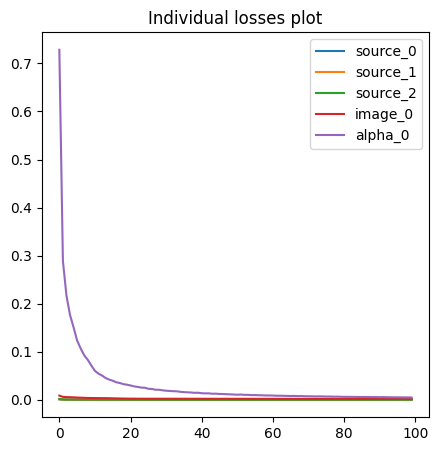

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

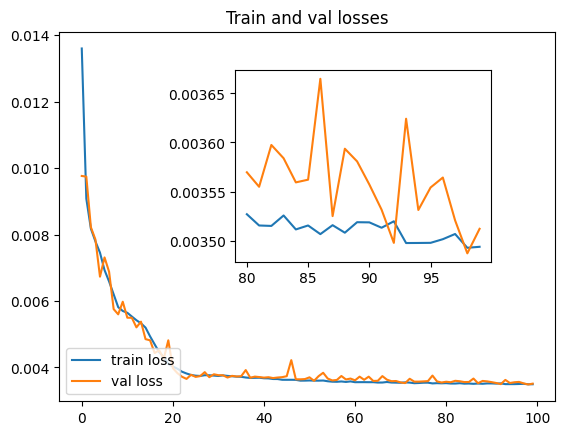

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.008292751920902553


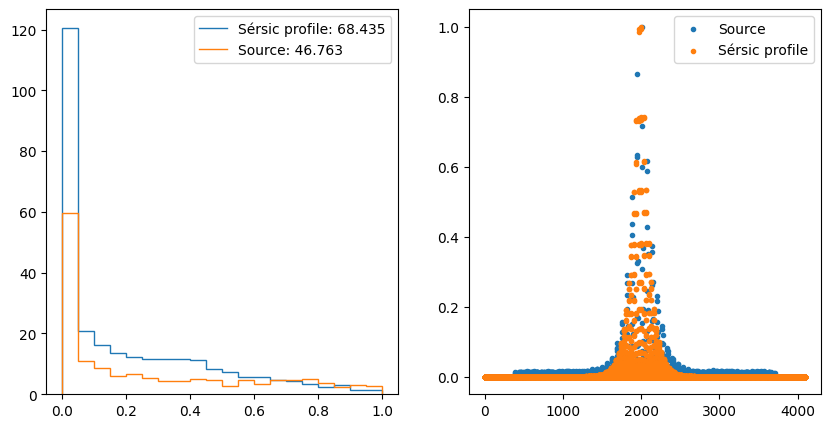

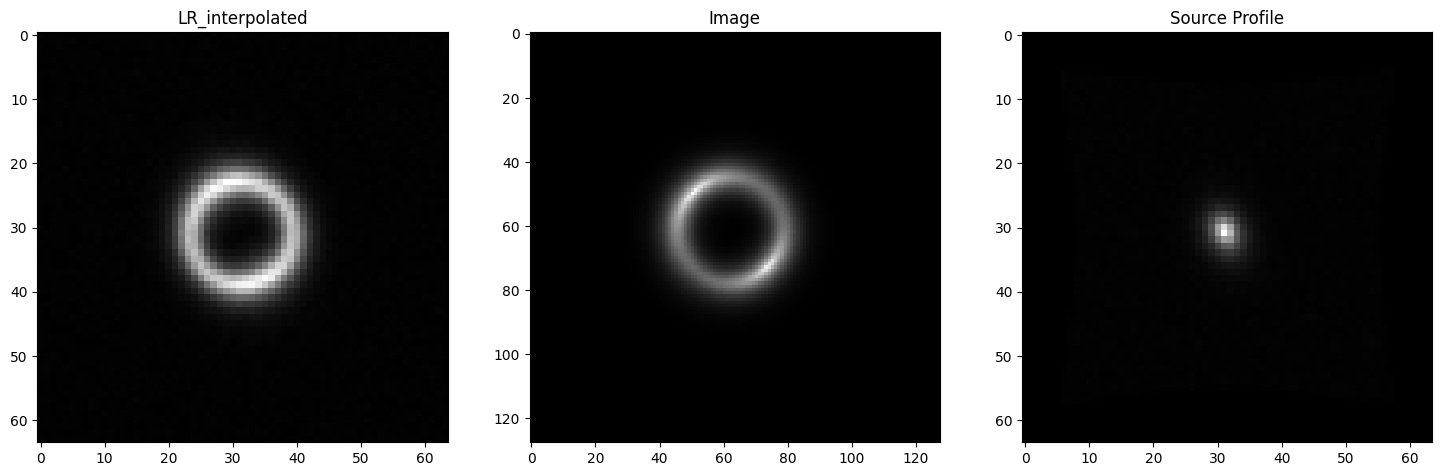

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_2.pt')